In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
from dataclasses import dataclass
from typing import Any, Iterable

In [2]:
# replace with `--root_output_dir` used in the experiments
ROOT_OUTPUT_DIR = 'output'
RESULTS_DIR = f'{ROOT_OUTPUT_DIR}/results'

In [31]:
def read_result(expr_file, metric_col_name):
    return pd.read_csv(expr_file, usecols=[metric_col_name], squeeze=True).rolling(200).mean()

In [32]:
@dataclass
class Task:
    title: str
    metric_col_name: str

STYLES = {
    'Float32': {'style': 'k-o'},
    'H-SQ': {'style': 'b-.x'},
    'K-SQ': {'style': 'r:>'},
    'EDEN': {'style': 'C8-.v'},    
}

METHOD_NAMES = {
    'Float32': 'Float32',
    'H-SQ': 'Hadamard + SQ',
    'K-SQ': 'Kashin + SQ',
    'EDEN': 'EDEN',
}
    
@dataclass
class Expr:
    display_name: str
    name: str
    series: Any = None
    
    @property
    def style(self):
        return STYLES[self.display_name]
        
@dataclass
class Plot:
    task: Task
    exprs: Iterable[Expr]
    zoom_range: Any = None

In [33]:
EMNIST = Task('EMNIST', 'sparse_categorical_accuracy')
SHAKESPEARE = Task('Shakespeare', 'accuracy')

In [46]:
PLOT_META = [
    # 0.1 b
    [ Plot(task=EMNIST, zoom_range=((1400, 1505), (0.815, 0.924)), exprs=[Expr('Float32', 'emnist_baseline'), Expr('H-SQ', 'emnist_hadamard0_1'), Expr('K-SQ', 'emnist_kashin0_1'), Expr('EDEN', 'emnist_eden0_1')]),
      Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.375, 0.620)), exprs=[Expr('Float32', 'shakespeare_baseline'), Expr('H-SQ', 'shakespeare_hadamard0_1'), Expr('K-SQ', 'shakespeare_kashin0_1'), Expr('EDEN', 'shakespeare_eden0_1')]) ],
    # 0.5 b
    [ Plot(task=EMNIST, zoom_range=((1400, 1505), (0.89, 0.9165)), exprs=[Expr('Float32', 'emnist_baseline'), Expr('H-SQ', 'emnist_hadamard0_5'), Expr('K-SQ', 'emnist_kashin0_5'), Expr('EDEN', 'emnist_eden0_5')]),
      Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.53, 0.61)), exprs=[Expr('Float32', 'shakespeare_baseline'), Expr('H-SQ', 'shakespeare_hadamard0_5'), Expr('K-SQ', 'shakespeare_kashin0_5'), Expr('EDEN', 'shakespeare_eden0_5')]) ],
    # 1 b
    [ Plot(task=EMNIST, zoom_range=((1400, 1505), (0.9003, 0.9165)), exprs=[Expr('Float32', 'emnist_baseline'), Expr('H-SQ', 'emnist_hadamard1'), Expr('K-SQ', 'emnist_kashin1'), Expr('EDEN', 'emnist_eden1')]),
      Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.55, 0.605)), exprs=[Expr('Float32', 'shakespeare_baseline'), Expr('H-SQ', 'shakespeare_hadamard1'), Expr('K-SQ', 'shakespeare_kashin1'), Expr('EDEN', 'shakespeare_eden1')]) ],
    # 2 b
    [ Plot(task=EMNIST, zoom_range=((1400, 1505), (0.910, 0.9152)), exprs=[Expr('Float32', 'emnist_baseline'), Expr('H-SQ', 'emnist_hadamard2'), Expr('K-SQ', 'emnist_kashin2'), Expr('EDEN', 'emnist_eden2')]),
      Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.581, 0.60)), exprs=[Expr('Float32', 'shakespeare_baseline'), Expr('H-SQ', 'shakespeare_hadamard2'), Expr('K-SQ', 'shakespeare_kashin2'), Expr('EDEN', 'shakespeare_eden2')]) ],
    # 4 b
    [ Plot(task=EMNIST, zoom_range=((1400, 1505), (0.91285, 0.9148)), exprs=[Expr('Float32', 'emnist_baseline'), Expr('H-SQ', 'emnist_hadamard4'), Expr('K-SQ', 'emnist_kashin4'), Expr('EDEN', 'emnist_eden4')]),
      Plot(task=SHAKESPEARE, zoom_range=((1100, 1205), (0.5945, 0.5995)), exprs=[Expr('Float32', 'shakespeare_baseline'), Expr('H-SQ', 'shakespeare_hadamard4'), Expr('K-SQ', 'shakespeare_kashin4'), Expr('EDEN', 'shakespeare_eden4')]) ],
]

In [47]:
for row in PLOT_META:
    for p in row:
        for e in p.exprs:
            expr_file = f'{RESULTS_DIR}/{e.name}/experiment.metrics.csv'
            if os.path.isfile(expr_file):
                try:
                    e.series = read_result(expr_file, p.task.metric_col_name)
                except:
                    print(f'got an error while reading experiment {e.name}')
            else:
                print(f'missing experiment: {e.name}')

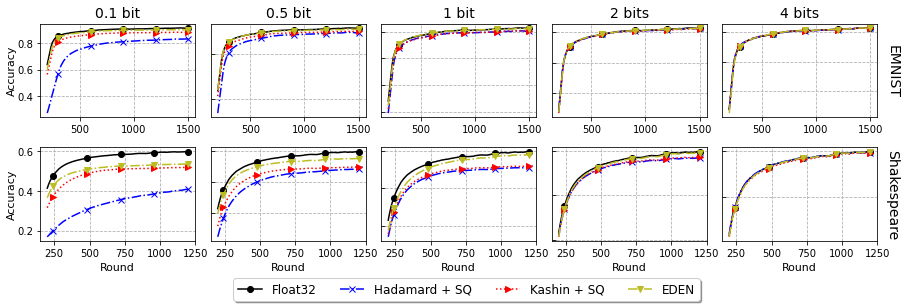

In [51]:
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)

fig, axs = plt.subplots(2, 5, figsize=(15, 4),  gridspec_kw={'hspace': 0.32, 'wspace': 0.1})
acc_label_offset = [0]* 5
bits_label = ['0.1 bit', '0.5 bit', '1 bit', '2 bits', '4 bits']

PLOT_META_T = [[PLOT_META[c][r] for c in range(5)] for r in range(2)]
for row, (r_axs, r_meta) in enumerate(zip(axs, PLOT_META_T)):
    r_axs[0].set_ylabel('Accuracy', fontsize=11, labelpad=acc_label_offset[row])
    r_axs[-1].yaxis.set_label_position("right")
    r_axs[-1].set_ylabel(r_meta[0].task.title, fontsize=14, rotation=270, labelpad=22)#, rotation=278, labelpad=22)
    
    for col, (ax, meta) in enumerate(zip(r_axs, r_meta)):
        if row == 0:
            ax.set_title(bits_label[col], fontsize=14)
        if col != 0:
            ax.tick_params(labelleft=False, axis="y", direction="in")
        x_range = meta.exprs[0].series.size
        markevery=max(x_range // 5, 1)
        for e in meta.exprs:
            if e.series is not None:
                e.series.plot(ax=ax, **e.style, legend=False, label=METHOD_NAMES[e.display_name], markevery=markevery)
            else:
                print(f'missing series {e.name}')
        ax.grid(linestyle='dashed')

for ax in axs[-1]:
    ax.set_xlabel('Round', fontsize=11)
handles, labels = axs[-1][-1].get_legend_handles_labels()
        
axs[1][2].legend(handles=handles,  # The line objects
                  labels=labels,  # The labels for each line
                   loc="lower center",  # Position of legend
                   bbox_to_anchor=(0.55, -0.65),
                   borderaxespad=0.1,  # Small spacing around legend box
                   shadow=True,
                   ncol=4,
                   fontsize=12)

fig.savefig('compare_fl_no_zoom.pdf', bbox_inches='tight')

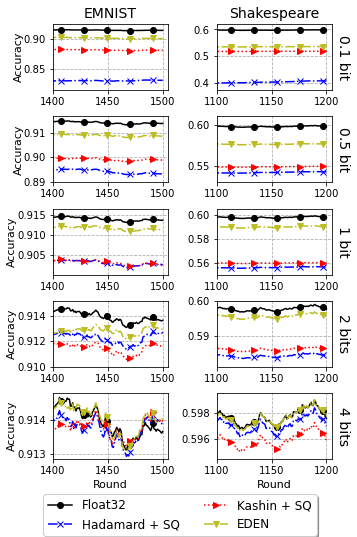

In [50]:
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)

fig, axs = plt.subplots(5, 2, figsize=(5, 8),  gridspec_kw={'hspace': 0.4, 'wspace': 0.42})
acc_label_offset = [0]* 5
bits_label = ['0.1 bit', '0.5 bit', '1 bit', '2 bits', '4 bits']

for row, (r_axs, r_meta) in enumerate(zip(axs, PLOT_META)):
    r_axs[0].set_ylabel('Accuracy', fontsize=11, labelpad=acc_label_offset[row])
    r_axs[1].yaxis.set_label_position("right")
    r_axs[1].set_ylabel(bits_label[row], fontsize=14, rotation=270, labelpad=18) #rotation=278, labelpad=22

    for ax, meta in zip(r_axs, r_meta):
        if row == 0:
            ax.set_title(meta.task.title, fontsize=14)
        if meta.zoom_range is not None:
            ax.set_xlim(meta.zoom_range[0])
            ax.set_ylim(meta.zoom_range[1])
            x_range = (meta.zoom_range[0][1] - meta.zoom_range[0][0])
        else:
            x_range = meta.exprs[0].series.size
        markevery=max(x_range // 5, 1)
        for e in meta.exprs:
            if e.series is not None:
                e.series.plot(ax=ax, **e.style, legend=False, label=METHOD_NAMES[e.display_name], markevery=markevery)
            else:
                print(f'missing series {e.name}')
        ax.grid(linestyle='dashed')

for ax in axs[-1]:
    ax.set_xlabel('Round', fontsize=11)
handles, labels = axs[-1][-1].get_legend_handles_labels()

fig.legend(handles=handles,  # The line objects
                  labels=labels,  # The labels for each line
                   loc="lower center",  # Position of legend
                   bbox_to_anchor=(0.5, 0),
                   borderaxespad=0.1,  # Small spacing around legend box
                   shadow=True,
                   ncol=2,
                   fontsize=12
                   )

fig.savefig('compare_fl.pdf', bbox_inches='tight')